# Goal

使用 resize 后的 image 训练，加大 train set 数据量。

# 训练细节

1. 每个 label 取 1k 图片时，训练速度提升 10x. 正确率同 v0，training acc 90%, val acc: 66%
2. 数据量增大 10 倍，每个 label 取 10k 图片，training acc 81%, val acc: 78%
3. epoch 从 5 改到 10，第 5 个 epoch 以后过拟合严重，train acc val acc 没有提高。


# Next Steps

1. 解 noisy label 导致的 loss

In [1]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np

import os
import time

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import json
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from PIL import Image

tf.__version__

'2.1.0'

# Load Datasets

In [2]:
DATA_DIR = '/home/jackon/datasets/porn_hot_images/resized-256x256'
# classes = ['drawings', 'hentai', 'neutral', 'porn', 'sexy']
labels = ['neutral', 'porn', 'sexy']
MAX_COUNT_PER_LABEL = 10000

In [3]:
def read_label_images(label):
    filepath = os.path.join(DATA_DIR, label)
    files = os.listdir(filepath)
    df1 = pd.DataFrame([os.path.join(DATA_DIR, label, f) for f in files])
    df1['label'] = label
    df1.columns = ['file', 'label']
    return df1

# df = read_label_images('sexy')
# df.head()

In [4]:
from PIL import Image


def preview_images(df, nrow=5, ncol=5):
    fig, axes = plt.subplots(nrow, ncol, figsize=(15, 20))
    for i, img_idx in enumerate(range(min(len(df), nrow * ncol))):
        item = df.iloc[i]
        image_obj = Image.open(item['file'])
        w, h = image_obj.size
        ax = axes.flat[i]
        ax.imshow(image_obj)
#         ax.set_title('pred: {}'.format(
#             ''.join(map(lambda i: b[i], y_pred[img_idx].numpy()))))
        ax.set_xlabel('true: {}. size: {} * {}'.format(item['label'], w, h))
        ax.set_xticks([])
        ax.set_yticks([])
# preview_images(df)

In [19]:
# read all images
from sklearn.utils import shuffle

df = pd.concat(read_label_images(label)[:MAX_COUNT_PER_LABEL] for label in labels)
df = shuffle(df)
df.head()

,file,label
6888,/home/jackon/datasets/porn_hot_images/resized-...,porn
8222,/home/jackon/datasets/porn_hot_images/resized-...,porn
4025,/home/jackon/datasets/porn_hot_images/resized-...,porn
501,/home/jackon/datasets/porn_hot_images/resized-...,sexy
2476,/home/jackon/datasets/porn_hot_images/resized-...,sexy


In [20]:
p = np.arange(len(df))

RATIO = 1

total = int(len(df) * RATIO)
train_up_to = int(total * 0.6)
valid_idx_to = int(total * 0.9)

train_idx = p[:train_up_to]
valid_idx = p[train_up_to:valid_idx_to]
test_idx = p[valid_idx_to:total]

print('train count: %s, valid count: %s, test count: %s' % (
    len(train_idx), len(valid_idx), len(test_idx)))

train count: 18000, valid count: 9000, test count: 3000


In [21]:
df[:total]['label'].value_counts()

neutral    10000
porn       10000
sexy       10000
Name: label, dtype: int64

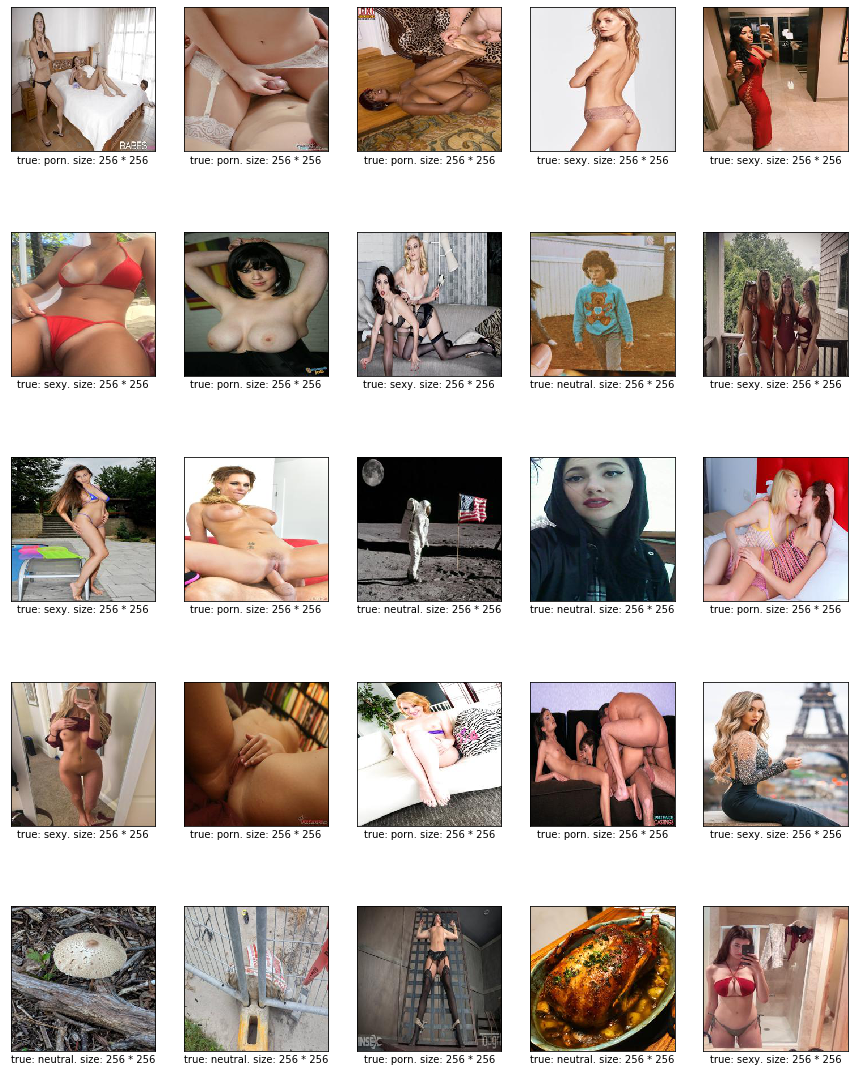

In [22]:
preview_images(df)

# label mapping

In [23]:
label2idx = {
    label: idx for idx, label in enumerate(labels)
}
label2idx

{'neutral': 0, 'porn': 1, 'sexy': 2}

In [24]:
idx2label = {
    idx: label for label, idx in label2idx.items()
}
idx2label

{0: 'neutral', 1: 'porn', 2: 'sexy'}

In [25]:
W, H, C = 256, 256, 3  # resized to 256x256 pixels
N_LABELS = len(labels)

In [26]:
from tensorflow.keras.utils import to_categorical
from PIL import Image
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

def get_data_generator(df, indices, for_training, batch_size=16):
    images, labels = [], []
    while True:
        for i in indices:
            r = df.iloc[i]
            file, label = r['file'], r['label']
            try:
                im = Image.open(file)
                if im.mode != 'RGB':
                    im = im.convert('RGB')
            except Exception as e:
                print('error image: %s' % file)
                print(e)
                continue

            im = im.resize((H, W))
            im = np.array(im) / 255.0
            if len(im.shape) != 3:
                print(im.shape)
                continue
            images.append(np.array(im))
            labels.append(np.array(
                to_categorical(label2idx[label], N_LABELS)
            ))
            if len(images) >= batch_size:
                yield np.array(images), np.array(labels)
                images, labels = [], []
        if not for_training:
            break

In [27]:
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Conv2D, MaxPool2D, GlobalMaxPool2D, Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Model


def conv_block(input_data, filters=32, bn=True, pool=True, kernel_size=3, activation='relu'):
    x = Conv2D(filters=filters, kernel_size=kernel_size, activation=activation)(input_data)
    if bn:
        x = BatchNormalization()(x)
    if pool:
        x = MaxPool2D()(x)
    return x

input_layer = tf.keras.Input(shape=(H, W, C))
x = layers.Conv2D(32, 3, activation='relu')(input_layer)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, 3, activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, 3, activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)

x = layers.Flatten()(x)
x = layers.Dense(1024, activation='relu')(x)
# x = layers.Dropout(0.5)(x)

x = layers.Dense(N_LABELS, activation='softmax')(x)

model = models.Model(inputs=input_layer, outputs=x)

model.compile(optimizer='adam', 
              loss='categorical_crossentropy',
              metrics= ['accuracy'])
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 125, 125, 64)      18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 60, 60, 64)        36928     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 30, 30, 64)        0   

In [28]:
from tensorflow.keras.callbacks import ModelCheckpoint

batch_size = 64
valid_batch_size = 64
train_gen = get_data_generator(df, train_idx, for_training=True, batch_size=batch_size)
valid_gen = get_data_generator(df, valid_idx, for_training=True, batch_size=valid_batch_size)

callbacks = [
    ModelCheckpoint("./model_checkpoint", monitor='val_loss')
]

history = model.fit(train_gen,
                    steps_per_epoch=len(train_idx)//batch_size,
                    epochs=10,
#                     callbacks=callbacks,
                    validation_data=valid_gen,
                    validation_steps=len(valid_idx)//valid_batch_size)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 281 steps, validate for 140 steps
Epoch 1/10
281/281 [==============================] - 72s 255ms/step - loss: 0.9303 - accuracy: 0.6019 - val_loss: 0.6636 - val_accuracy: 0.7169
Epoch 2/10
281/281 [==============================] - 65s 230ms/step - loss: 0.6024 - accuracy: 0.7449 - val_loss: 0.5842 - val_accuracy: 0.7513
Epoch 3/10
281/281 [==============================] - 66s 234ms/step - loss: 0.4984 - accuracy: 0.7954 - val_loss: 0.5649 - val_accuracy: 0.7627
Epoch 4/10
281/281 [==============================] - 65s 232ms/step - loss: 0.4066 - accuracy: 0.8378 - val_loss: 0.6579 - val_accuracy: 0.7475
Epoch 5/10
281/281 [==============================] - 66s 234ms/step - loss: 0.3122 - accuracy: 0.8791 - val_loss: 0.7504 - val_accuracy: 0.7365
Epoch 6/10
281/281 [==============================] - 66s 235ms/step - loss: 0.2126 - accuracy: 0.9195 - val_loss: 0.9936 - val_accuracy: 0.7305
Epoch 7/10
281/281 [================

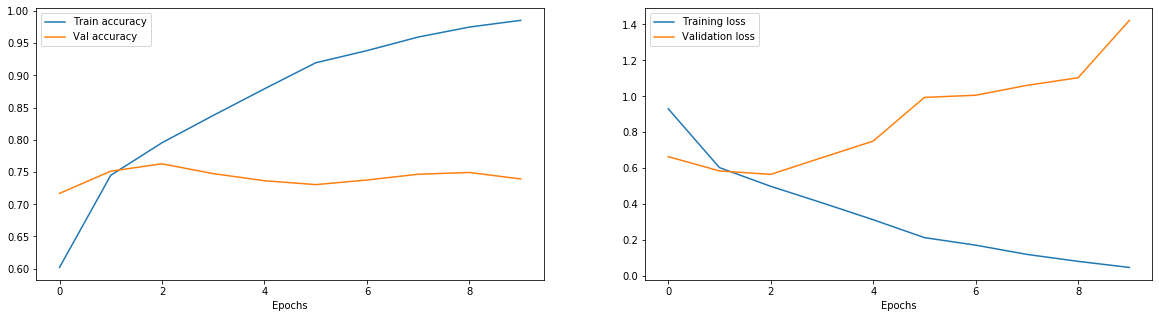

In [29]:
def plot_train_history(history):
    fig, axes = plt.subplots(1, 2, figsize=(20, 5))

    axes[0].plot(history.history['accuracy'], label='Train accuracy')
    axes[0].plot(history.history['val_accuracy'], label='Val accuracy')
    axes[0].set_xlabel('Epochs')
    axes[0].legend() 

    axes[1].plot(history.history['loss'], label='Training loss')
    axes[1].plot(history.history['val_loss'], label='Validation loss')
    axes[1].set_xlabel('Epochs')
    axes[1].legend()

plot_train_history(history)

In [32]:
test_gen = get_data_generator(df, test_idx, for_training=False, batch_size=128)
dict(zip(model.metrics_names, model.evaluate(test_gen, steps=len(test_idx)//128)))

  ...
    to  
  ['...']
23/23 [==============================] - 7s 301ms/step - loss: 1.5370 - accuracy: 0.7130


{'loss': 1.5370365899542104, 'accuracy': 0.71297556}

In [33]:
test_gen = get_data_generator(df, test_idx, for_training=False, batch_size=128)
x_test, y_test = next(test_gen)

y_pred = model.predict_on_batch(x_test)

y_true = tf.math.argmax(y_test, axis=-1)
y_pred = tf.math.argmax(y_pred, axis=-1)

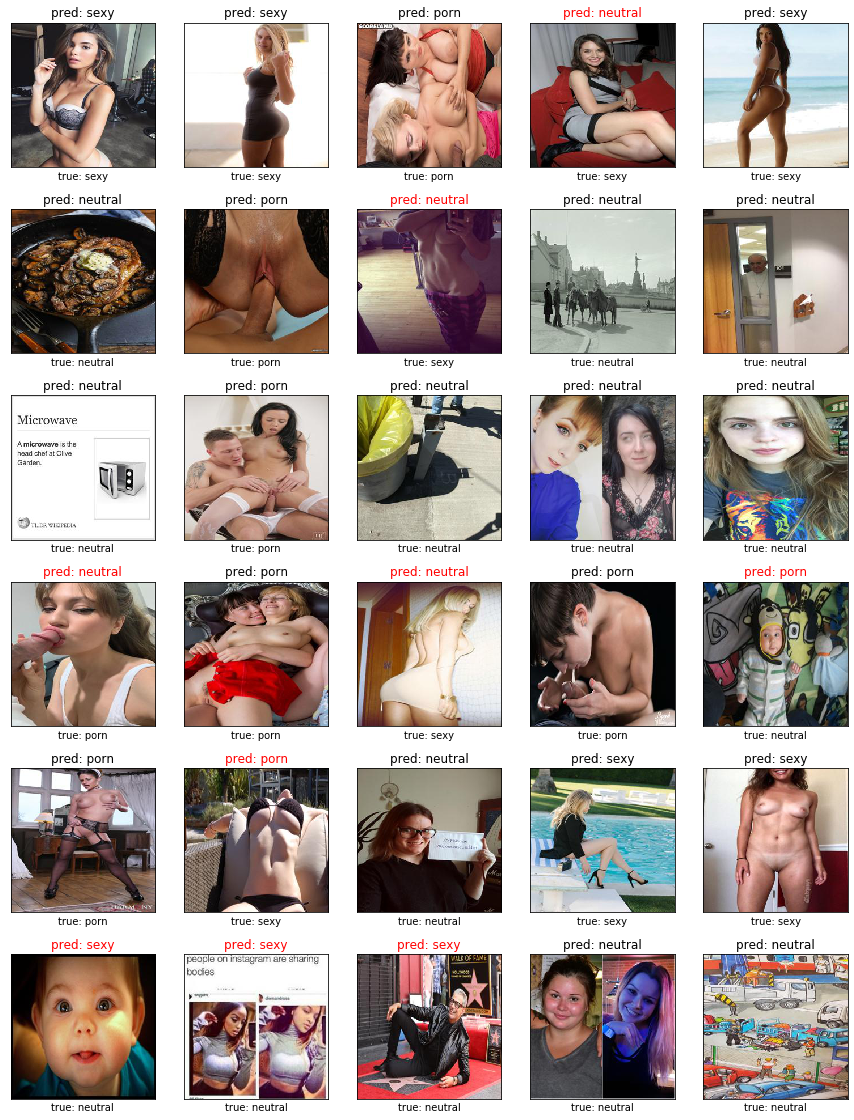

In [34]:
import math
n = 30
random_indices = np.random.permutation(n)
n_cols = 5
n_rows = math.ceil(n / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 20))
for i, img_idx in enumerate(random_indices):
    ax = axes.flat[i]
    ax.imshow(x_test[img_idx])
    pred = idx2label[y_pred[img_idx].numpy()]
    ground_truth = idx2label[y_true[img_idx].numpy()]
    if pred != ground_truth:
        color = 'r'
    else:
        color = 'k'
    ax.set_title('pred: {}'.format(pred), color=color)
    ax.set_xlabel('true: {}'.format(ground_truth))
    ax.set_xticks([])
    ax.set_yticks([])